In [1]:
import time
import os
import os.path as osp
import sys
import io
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from astroML.datasets import sdss_corrected_spectra
from models import *

import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device Used: " + str(device))

print(torch.get_num_threads())

# set random seed
manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Device Used: cpu
4


Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=114, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=114, out_features=178, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Linear(in_features=178, out_features=243, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(243, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Linear(in_features=243, out_features=

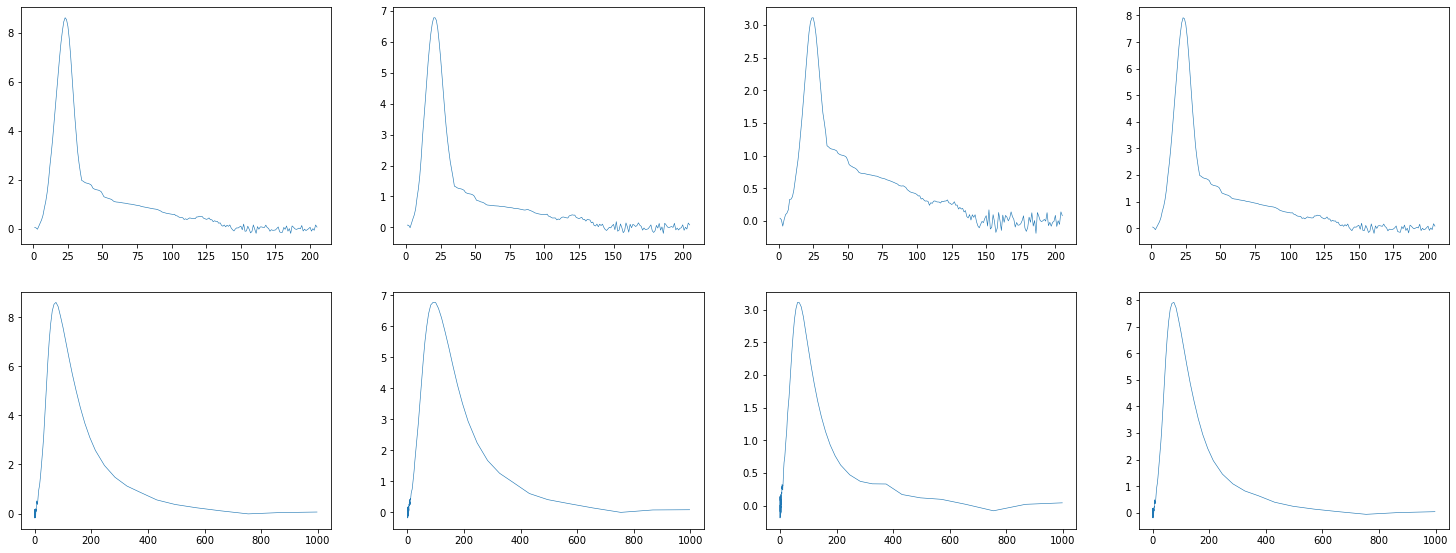

In [2]:
### Config

## Data 

data_folder = "./Data"
training_data = np.load(osp.join(data_folder, "spectra_complete_training_fixed_ids.npy")).astype(np.float32)
test_data = np.load(osp.join(data_folder, "spectra_complete_testing_fixed_ids.npy"))

TRAINING_DATA = training_data.shape[0]
TEST_DATA = test_data.shape[0]
FEATURE_SIZE = training_data.shape[1]

# DELETE VERY HIGH WAVELENGTHS
training_data = training_data[:,18:] #114
test_data = test_data[:,18:]
TRAINING_DATA = training_data.shape[0]
TEST_DATA = test_data.shape[0]
FEATURE_SIZE = training_data.shape[1]

LATENT_SIZE = 50

#number of wavelenths
NLA = 223
NLA_reduced = 20
# contains all wavelenghts
wavelength_values = np.loadtxt(osp.join(data_folder, 'wavelengths_complete_reduced_serial.txt')) 
wavelength_values_reduced = sorted(wavelength_values[:NLA_reduced]) # ascending order
wavelength_values_complete = sorted(wavelength_values[NLA_reduced:])# ascending order
wavelengths = np.array(range(1, FEATURE_SIZE+1))

# DELETE VERY HIGH WAVELENGTHS
NLA = NLA - 18
#NLA = 109
wavelength_values_complete = wavelength_values_complete[:NLA]

## Model

model = "glo"

if model=="glo":
    result_folder = './GLOres/GLOres_complete_' #low_wvs
if model=="gan": 
    result_folder = './GANres/GANres_complete_'

from solve_inverse import *
#from evaluation import *
from statistics import mean
from math import sqrt

## Model
evaluator = nn.MSELoss()

# GLO training requires restriction of latent code in the l2 unit ball 
def project_l2_ball(z):
    """ project the vectors in z onto the l2 unit norm ball"""
    z_l2_norm = torch.norm(z, p=2, dim=0).detach()
    if z_l2_norm.item() > 1:
        z = z.div(z_l2_norm.expand_as(z))
    return z

d = 5
netG = Generator(nz=LATENT_SIZE, nf=FEATURE_SIZE, num_hidden_layers=d)
netG.eval()

if model=="gan":
    iter_saved = 900
if model=="glo":
    iter_saved = 10000 #5000
    latent = torch.load(osp.join(result_folder,"learned_latent_codes.pth"))
    
netG.load_state_dict(torch.load(osp.join(result_folder,"learned_generator_" + str(iter_saved) + ".pth")))
print(netG)

#plot a random sample (4) generated by netG
latent_rand = torch.randn(4, LATENT_SIZE, device=device)
if model=="glo":
    for i in range(4):
        latent_rand[i] = project_l2_ball(latent_rand[i])
    

#change font size
plt.rcParams.update({'font.size':10})
fig = plt.figure(figsize=[4*6.4, 2*4.8])
ax1_u = fig.add_subplot(241)
ax2_u = fig.add_subplot(242)
ax3_u = fig.add_subplot(243)
ax4_u = fig.add_subplot(244)
axis_u = [ax1_u,ax2_u,ax3_u,ax4_u]

ax1_d = fig.add_subplot(245)
ax2_d = fig.add_subplot(246)
ax3_d = fig.add_subplot(247)
ax4_d = fig.add_subplot(248)
axis_d = [ax1_d,ax2_d,ax3_d,ax4_d]

# Argument explanation: grid with 2 x 4 images (2 rows, 4 columns), 
#                       last argument is counting from left to right and top to bottom

for i in range(4):
    sample = netG(latent_rand[i].unsqueeze(0)).squeeze(0).detach().numpy()
    sample_asc = np.flip(sample)
    axis_u[i].plot(wavelengths, sample, linewidth=0.6)
    axis_d[i].plot(wavelength_values_complete, sample_asc, linewidth=0.6)

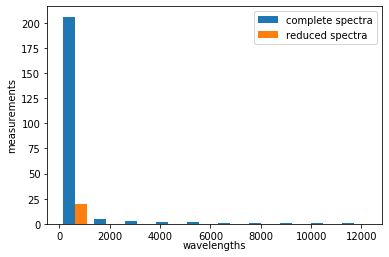

In [13]:
# Wavelength Values

fig, ax = plt.subplots()
ax.hist([wavelength_values_complete, wavelength_values_reduced], label=["complete spectra", "reduced spectra"])

plt.legend()
plt.xlabel('wavelengths', ha='center', va='center') # $(\AA)$
plt.ylabel('measurements')

fig.savefig("wavelength_stats.jpg")

In [1]:
# Sample Spectra

spectra = np.load(osp.join(data_folder, "spectra_complete.npy")).astype(np.float32)
SPECTRA_NUM = spectra.shape[0]


id = random.randint(0,SPECTRA_NUM)
print(id)
signal = spectra[id]
#wavelength values are in ascenting order whereas signal values are in the descending order.
signal = np.flip(signal)


fig, ax = plt.subplots()
ax.plot(wavelength_values_complete, signal[:NLA], alpha=0.7, linewidth=0.6)
#logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('wavelength $(\u03bcm)$', ha='center', va='center')
plt.ylabel('flux', ha='center', va='center', rotation='vertical')
    
fig.savefig("sample_signal_" + str(id) +".pdf", bbox_inches='tight')

NameError: name 'np' is not defined

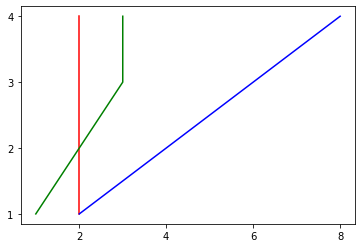

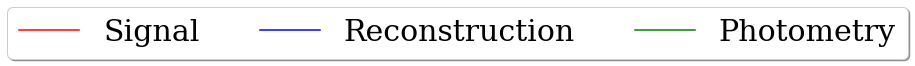

In [2]:
## Legend

fig, ax = plt.subplots()

#legend_text = ["Signal", "Reconstruction", "Missing"]
legend_text = ["Signal", "Reconstruction", "Photometry"]

ax.plot([2,2,2,2], [1,2,3,4], label=legend_text[0], color = 'red')
ax.plot([2,4,6,8], [1,2,3,4], label=legend_text[1], color = 'blue')
ax.plot([1,2,3,3], [1,2,3,4], label=legend_text[2], color = 'green')

#plt.rc('text', usetex=True)  
plt.rc('font', family='serif', size=20) 

h, l = ax.get_legend_handles_labels()
figlegend = plt.figure(figsize=(4 * len(legend_text), 0.5))
ax_leg = figlegend.add_subplot(111)
ax_leg.legend(h, l, loc='center', ncol=len(legend_text), fancybox=True, shadow=True, prop={'size':30}, markerscale=2)
ax_leg.axis('off')
figlegend.savefig("legend_real.pdf", format="pdf", bbox_inches="tight")

Measured wavelength values:
[0.051, 0.076333, 0.11833, 0.21667, 0.26367, 0.30267, 0.326, 0.41367, 0.53667, 0.72333, 1.1853, 1.5003, 1.915, 2.6393, 7.8647]
109
Reconstruction of id 3654
Epoch [100/1000], Loss: 0.0040
Epoch [200/1000], Loss: 0.0040
Epoch [300/1000], Loss: 0.0040
Epoch [400/1000], Loss: 0.0040
Epoch [500/1000], Loss: 0.0040
Epoch [600/1000], Loss: 0.0040
Epoch [700/1000], Loss: 0.0040
Epoch [800/1000], Loss: 0.0040
Epoch [900/1000], Loss: 0.0040
Epoch [1000/1000], Loss: 0.0040
Reconstruction of id 2233
Epoch [100/1000], Loss: 0.0044
Epoch [200/1000], Loss: 0.0044
Epoch [300/1000], Loss: 0.0045
Epoch [400/1000], Loss: 0.0044
Epoch [500/1000], Loss: 0.0045
Epoch [600/1000], Loss: 0.0045
Epoch [700/1000], Loss: 0.0045
Epoch [800/1000], Loss: 0.0045
Epoch [900/1000], Loss: 0.0044
Epoch [1000/1000], Loss: 0.0044
Reconstruction of id 356
Epoch [100/1000], Loss: 0.0048
Epoch [200/1000], Loss: 0.0047
Epoch [300/1000], Loss: 0.0047
Epoch [400/1000], Loss: 0.0048
Epoch [500/1000], 

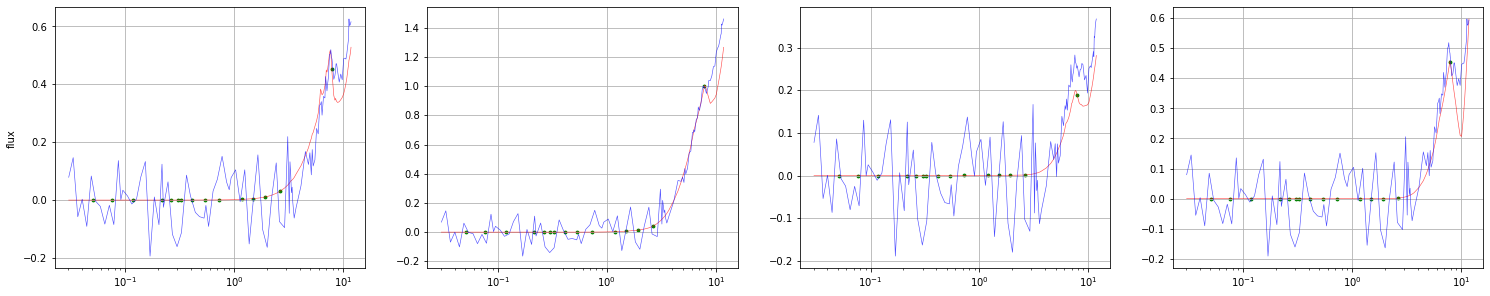

In [4]:
## SUPER-RESOLUTION real application

from bisect import bisect

inverse_problem = "superresolution_real"


# DELETE VERY HIGH WAVELENGTHS
NLA_reduced = 20
NLA_reduced = NLA_reduced - 5 #discard last 5 measurements
wavelength_values_reduced = sorted(wavelength_values[:NLA_reduced])
wavelength_values_reduced = wavelength_values_reduced[:NLA_reduced]
print("Measured wavelength values:")
print(wavelength_values_reduced)



res_dir = osp.join(result_folder, model + "_qualitative_real_low")
if not osp.exists(res_dir):
    os.mkdir(res_dir)

## Construct The A matrix for the real superresolution application
A_superres_real = torch.zeros((NLA_reduced, NLA), device=device)

for i,wv in enumerate(wavelength_values_reduced):
    idx = bisect(wavelength_values_complete, wv)
    A_superres_real[i][idx] = 0.5
    A_superres_real[i][idx+1] = 0.5
A_superres_real = torch.flip(A_superres_real,[1])



## Config
# data to test on
real_reduced_data = np.load(osp.join(data_folder, "spectra_reduced_testing_fixed_ids.npy")).astype(np.float32)
REDUCED_DATA = real_reduced_data.shape[0]
REDUCED_FEATURES = real_reduced_data.shape[1]
ids = random.sample(range(0,REDUCED_DATA), 4)

ids = [3654, 2233, 356, 2418]

# maximum wavelength from the complete spectrum that is relevant to the reduced spectrum
max_wavelength_reduced = max(wavelength_values_reduced)
buff = round(max_wavelength_reduced*0.5)
NLA_max = len([wv for wv in wavelength_values_complete if wv <= max_wavelength_reduced+buff])
print(NLA_max)
# save runs
verbose = True
rerun = True
if rerun and not osp.exists(osp.join(res_dir, "saved_runs")):
    os.mkdir(osp.join(res_dir, "saved_runs"))
    

#change font size
plt.rcParams.update({'font.size':10})
fig = plt.figure(figsize=[4*6.4, 4.8])
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
axis = [ax1,ax2,ax3,ax4]

## Solve the inverse problem

for cnt,i in enumerate(ids):
    if rerun:
        print("Reconstruction of id " + str(i))
        # measurements
        y = torch.tensor(real_reduced_data[i][:NLA_reduced], device=device)
        # real super-res application
        A = A_superres_real
        # solve inverse
        z = solve_inverse(netG, y, A, LATENT_SIZE, device, max_epochs=1000, lr=0.05, 
                          optm="adam", regularization_lambda=0.01, verbose=verbose)
        inv = netG(z.unsqueeze(0)).squeeze(0).detach()
        #get original signal 
        original = test_data[i]
        #save run
        y = y.numpy()
        # pad measurements to match high-dim data
        y_padded = np.pad(y,(0, NLA - NLA_reduced), 'constant')
        inv = inv.numpy()
        to_save = np.vstack((y_padded, inv, original))
        np.save(osp.join(res_dir, "saved_runs", inverse_problem+"__y_padded-inv_fig" + str(cnt) +".npy"), to_save)
    else:
        data = np.load(osp.join(res_dir, "saved_runs", inverse_problem+"__y_padded-inv_fig" + str(cnt) +".npy"))
        y = data[0]
        # un-pad measurements
        y = y[:NLA_reduced]
        inv = data[1]
        original = data[2]
    #create fig
    axis[cnt].scatter(wavelength_values_reduced, y, s=8, color = 'green')
    #wavelength values are in ascenting order whereas signal values are in the descending order.
    inv = np.flip(inv)
    #plot the signal only in the region of importance. (computed by NLA_max)
    original = np.flip(original)
    axis[cnt].plot(wavelength_values_complete[:NLA_max], original[:NLA_max], alpha=0.7, linewidth=0.6, color = 'red')
    axis[cnt].plot(wavelength_values_complete[:NLA_max], inv[:NLA_max], alpha=0.7, linewidth=0.6, color = 'blue')
    axis[cnt].set_xscale('log')
    axis[cnt].grid()
    
    
# Set common labels
#fig.text(0.5, 0.03, 'wavelength $(\AA)$', ha='center', va='center')
fig.text(0.102, 0.5, 'flux', ha='center', va='center', rotation='vertical')
fig.savefig(osp.join(res_dir,inverse_problem + ".pdf"), bbox_inches='tight')

Epoch [100/1000], Loss: 0.7191
Epoch [200/1000], Loss: 0.5341
Epoch [300/1000], Loss: 0.3744
Epoch [400/1000], Loss: 0.2812
Epoch [500/1000], Loss: 0.2207
Epoch [600/1000], Loss: 0.1757
Epoch [700/1000], Loss: 0.1042
Epoch [800/1000], Loss: 0.0710
Epoch [900/1000], Loss: 0.0512
Epoch [1000/1000], Loss: 0.0382
Reconstruction Error of id 1516 :
0.0369
Epoch [100/1000], Loss: 0.6306
Epoch [200/1000], Loss: 0.5737
Epoch [300/1000], Loss: 0.5303
Epoch [400/1000], Loss: 0.4931
Epoch [500/1000], Loss: 0.4585
Epoch [600/1000], Loss: 0.4255
Epoch [700/1000], Loss: 0.3937
Epoch [800/1000], Loss: 0.3644
Epoch [900/1000], Loss: 0.3354
Epoch [1000/1000], Loss: 0.3083
Reconstruction Error of id 1455 :
0.015
Epoch [100/1000], Loss: 0.0787
Epoch [200/1000], Loss: 0.0203
Epoch [300/1000], Loss: 0.0118
Epoch [400/1000], Loss: 0.0113
Epoch [500/1000], Loss: 0.0113
Epoch [600/1000], Loss: 0.0113
Epoch [700/1000], Loss: 0.0124
Epoch [800/1000], Loss: 0.0122
Epoch [900/1000], Loss: 0.0124
Epoch [1000/1000],

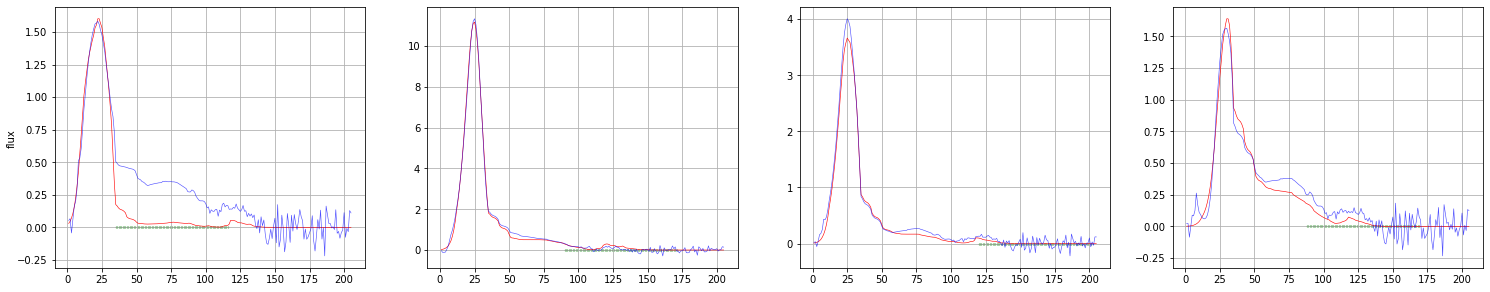

In [28]:
## QUALITATIVE on missing information problems
# Evaluation on Test Data  
# -> figure with multiple random signals , missing info : inpainting/superres  ++ reconstruction

res_dir = osp.join(result_folder, model + "_qualitative")
if not osp.exists(res_dir):
    os.mkdir(res_dir)

## Inverse Problems

inverse_problem = "inpainting" #superresolution, reconstruction

#missing info 
missing_perc = 40
missing = round(FEATURE_SIZE*missing_perc/100)
    
#data to test on
ids = random.sample(range(0,TEST_DATA), 4)
data_to_test_on = test_data

verbose = True
rerun = True
if rerun and not osp.exists(osp.join(res_dir, "saved_runs")):
    os.mkdir(osp.join(res_dir, "saved_runs"))

#change font size
plt.rcParams.update({'font.size':10})
fig = plt.figure(figsize=[4*6.4, 4.8])
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
axis = [ax1,ax2,ax3,ax4]


for cnt,i in enumerate(ids):
    if rerun:
        # inverse test
        x = torch.tensor(data_to_test_on[i], device=device)
        if inverse_problem == "inpainting":
            #inpainting, missing window
            A = torch.eye(FEATURE_SIZE, device=device) 
            start = random.randint(0,FEATURE_SIZE-missing)
            end = start + missing
            A[range(start,end)] = 0
        if inverse_problem == "superresolution":
            #superresolution, missing random values
            A = torch.eye(FEATURE_SIZE, device=device) 
            missing_elements = random.sample(range(0,FEATURE_SIZE), missing)
            A[missing_elements] = 0
        if inverse_problem == "reconstruction":
            #no missing information
            A = torch.eye(FEATURE_SIZE, device=device)
        # get measurements
        y = torch.matmul(A,x)
        z = solve_inverse(netG, y, A, LATENT_SIZE, device, max_epochs=1000, lr=0.1, 
                          optm="adam", regularization_lambda=0.01, verbose=verbose)
        inv = netG(z.unsqueeze(0)).squeeze(0).detach()
        print("Reconstruction Error of id " + str(i) + " :")
        print(round(evaluator(x,inv).item(),4))
        #save run
        y = y.numpy()
        x = x.numpy()
        inv = inv.numpy()
        to_save = np.vstack((y, x, inv))
        np.save(osp.join(res_dir, "saved_runs", inverse_problem+"__y-x-inv_fig" + str(cnt) +".npy"), to_save)
    else:
        data = np.load(osp.join(res_dir, "saved_runs", inverse_problem+"__y-x-inv_fig" + str(cnt) +".npy"))
        y = data[0]
        x = data[1]
        inv = data[2]
    #create fig
    axis[cnt].scatter(wavelengths[np.where(y == 0)[0]], y[np.where(y == 0)[0]], s=0.5, color = 'green')
    axis[cnt].plot(wavelengths, x, linewidth=0.6, color = 'red')
    axis[cnt].plot(wavelengths, inv, alpha=0.7, linewidth=0.6, color = 'blue')
    axis[cnt].grid()
    
    
# Set common labels
#fig.text(0.5, 0.03, 'wavelength $(\AA)$', ha='center', va='center')
fig.text(0.102, 0.5, 'flux', ha='center', va='center', rotation='vertical')
if inverse_problem == "reconstruction":
    fig.savefig(osp.join(res_dir,inverse_problem + "_test_data.pdf"), bbox_inches='tight')
else:
    fig.savefig(osp.join(res_dir,inverse_problem + "_" + str(missing_perc) + "perc_test_data.pdf"), 
                bbox_inches='tight')
    

In [ ]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################
####################################### BEWARE #################################################
################################ BELLOW LIES OLD CODE ##########################################
################################################################################################
################################################################################################
################################################################################################
################################################################################################
################################################################################################

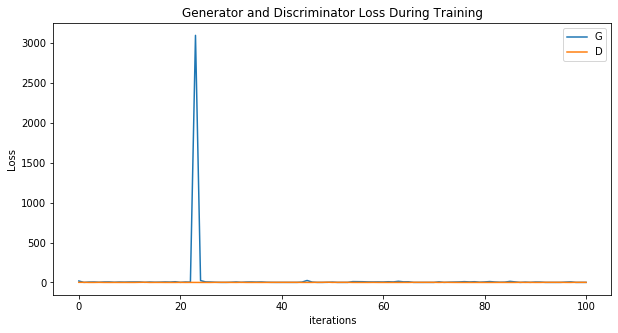

In [3]:
# training stats
# plot of D & G’s losses versus training iterations

G_losses = np.load(osp.join(result_folder, "G_losses.npy"))
D_losses = np.load(osp.join(result_folder, "D_losses.npy"))

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(osp.join(result_folder, "training_stats.jpg"))

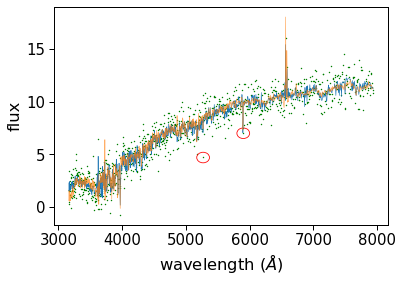

In [101]:
## QUALITATIVE on denoising problems
# Evaluation on Test Data  -> figure with multiple random signals

res_dir = osp.join(result_folder, model + "_qualitative_test")
if not osp.exists(res_dir):
    os.mkdir(res_dir)
    
inverse_problem = "denoising"

#change font size
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots()

data = np.load(osp.join(res_dir, "saved_runs", inverse_problem+"__y-x-inv_fig" + str(1) +".npy"))
y = data[0]
x = data[1]
inv = data[2]
#create fig
ax.scatter(wavelengths, y, s=0.4, color = 'green')
ax.plot(wavelengths, x, linewidth=0.6)
ax.plot(wavelengths, inv, alpha=0.7,  linewidth=0.6)
#ax.grid()

circle1 = matplotlib.patches.Ellipse((5900, 7), 200, 1, color='red', fill=False)
circle2 = matplotlib.patches.Ellipse((5270, 4.7), 200, 1, color='red', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

ax.set(xlabel='wavelength $(\AA)$', ylabel='flux')
fig.savefig(osp.join(res_dir,inverse_problem + "_example.pdf"), bbox_inches='tight')

Inpainting
[ 5 10 20 30 40 60 80]
Number of outliers discarded 0 out of 100 samples (test)
Number of outliers discarded 0 out of 100 samples (training + reg)
Number of outliers discarded 3 out of 100 samples (test + reg)


<function matplotlib.pyplot.show(*args, **kw)>

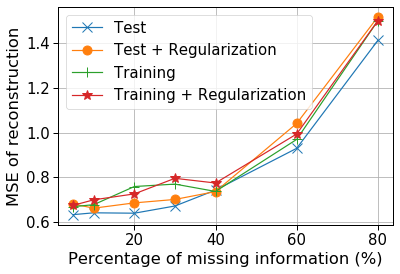

In [46]:
## Visualize inpainting (medians, quantitative)

num_samples = 100

dir_to_vis = osp.join(result_folder, model + "_quantitative")
inverse_problem = "inpainting" #  superresolution inpainting
print("Inpainting")
missing_vals = np.load(osp.join(dir_to_vis, inverse_problem + "_missing.npy"))
print(missing_vals)

err_all_test = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all.npy"))
err_all_training = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_training.npy"))
err_all_training_noreg = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_training_noreg.npy"))
err_all_test_reg = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_reg.npy"))

# outlier detection
ids_outliers = np.argwhere(err_all_test[0] > 1000)
print("Number of outliers discarded " + str(ids_outliers.shape[0]) + " out of " + str(num_samples) 
      + " samples (test)")
err_clean = np.delete(err_all_test, ids_outliers.flatten(), axis=1)
err_clean_mean = np.mean(err_clean, axis=1)
err_test_median = np.median(err_all_test, axis=1)

ids_outliers = np.argwhere(err_all_training[0] > 1000)
print("Number of outliers discarded " + str(ids_outliers.shape[0]) + " out of " + str(num_samples) 
        + " samples (training + reg)")
err_clean_training = np.delete(err_all_training, ids_outliers.flatten(), axis=1)
err_clean_mean_training = np.mean(err_clean_training, axis=1)
err_training_reg_median = np.median(err_all_training, axis=1)
err_training_noreg_median = np.median(err_all_training_noreg, axis=1)


ids_outliers = np.argwhere(err_all_test_reg[0] > 100)
print("Number of outliers discarded " + str(ids_outliers.shape[0]) + " out of " + str(num_samples) 
      + " samples (test + reg)")
err_clean_test_reg = np.delete(err_all_test_reg, ids_outliers.flatten(), axis=1)
err_clean_mean_test_reg = np.mean(err_clean_test_reg, axis=1)
err_test_reg_median = np.median(err_all_test_reg, axis=1)



err_test_median = np.median(err_all_test, axis=1)
err_training_noreg_median = np.median(err_all_training_noreg, axis=1)


plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots()
line1, = ax.plot(missing_vals, err_test_median, marker='x', markersize=10)
line2, = ax.plot(missing_vals, err_test_reg_median, marker='o', markersize=9)
line3, = ax.plot(missing_vals, err_training_noreg_median, marker='+', markersize=10)
line4, = ax.plot(missing_vals, err_training_reg_median, marker='*', markersize=10)



ax.set(xlabel='Percentage of missing information (%)', ylabel='MSE of reconstruction')
ax.grid()
ax.legend((line1, line2, line3, line4),('Test', 'Test + Regularization', 
                                        'Training', 'Training + Regularization'), fancybox=True)
#ax.legend((line2, line4),('Test + Regularization', 'Training + Regularization'), fancybox=True)
fig.savefig(osp.join(dir_to_vis, inverse_problem + "_errs_clean_allll.pdf"), bbox_inches='tight')
plt.show

Inpainting
[ 5 10 20 30 40 60 80]
[ 5 10 20 30 40 60 80]


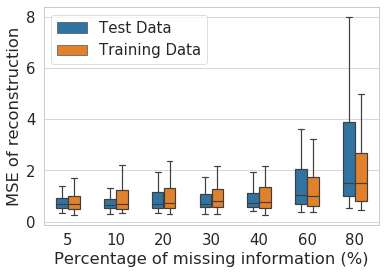

In [109]:
## Visualize inpainting (quantitative)

num_samples = 100
configs = ["Test Data", "Training Data"]

dir_to_vis = osp.join(result_folder, model + "_quantitative")
inverse_problem = "inpainting" #superresolution inpainting
print("Inpainting")
missing_vals = np.load(osp.join(dir_to_vis, inverse_problem + "_missing.npy"))
print(missing_vals)
missing_vals_new = np.load(osp.join(dir_to_vis, inverse_problem + "_missing_newtraining_newlr.npy"))
print(missing_vals_new)


err_all_test = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all.npy"))
err_all_test = np.delete(err_all_test, 6, 0)
err_all_training = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_training_noreg.npy"))
err_all_training = np.delete(err_all_training, 6, 0)
err_all_training_newlr = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_newtraining_newlr.npy"))
err_all_training_newlr = np.delete(err_all_training_newlr, 6, 0)
err_all_test_reg = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_reg.npy"))
#err_all_test_reg = np.delete(err_all_test_reg, 6, 0)
err_all_training_reg = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_training.npy"))
#err_all_training_reg = np.delete(err_all_training_reg, 6, 0)


#box and wiskers
data_to_plot = {}
x_axis = missing_vals.tolist()
#x_axis = [x_axis[i//num_samples] for i in range((len(x_axis)-1)*num_samples)]
x_axis = [x_axis[i//num_samples] for i in range((len(x_axis))*num_samples)]
data_to_plot["x"] = x_axis
data_to_plot["Test Data"] = err_all_test_reg.flatten().tolist()
data_to_plot["Training Data"] = err_all_training_reg.flatten().tolist()

# Put the data in a dataframe
df = pd.DataFrame.from_dict(data_to_plot)
# Group by x
dd = pd.melt(df, id_vars="x", value_vars=configs, var_name='configs')

# Set fonts
sns.set_context("paper", font_scale=1.7)

sns.set_style("whitegrid")

# Also show the mean
meanprops = dict(marker='o', color='black', markeredgecolor='black', markerfacecolor='black', markersize=4)
# Plot
sns_plot = sns.boxplot(x="x", y="value", data=dd,hue='configs', width=0.5, whis = 1.5,
                       showfliers = False, meanprops = meanprops)

# Remove the legend from the figure
#sns_plot.legend_.remove()
# Remove the legend title from the legend
sns_plot.legend_.set_title('')

# Save the figure
#sns_plot.set_yscale('log', basey=2)
sns_plot.set(xlabel='Percentage of missing information (%)', ylabel='MSE of reconstruction')
fig = sns_plot.get_figure()

#fig.savefig("plot.pdf", format="pdf", bbox_inches="tight")

fig.savefig(osp.join(dir_to_vis, inverse_problem + "_test_training_boxNwiskers.pdf"), 
            format="pdf", bbox_inches='tight')
plt.show()

Denoising
[ 5 10 20 40 80]
(4, 100)
(4, 100)


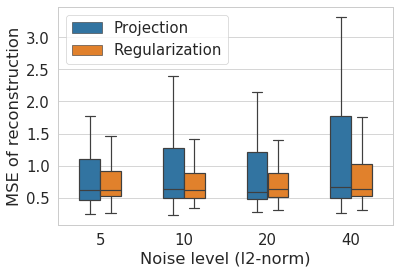

In [110]:
## Visualize denoising (quantitative)
num_samples = 100 

dir_to_vis = osp.join(result_folder, model + "_quantitative")
inverse_problem = "denoising" # superresolution inpainting
print("Denoising")
noise_vals = np.load(osp.join(dir_to_vis, inverse_problem + "_noise_level_newlr.npy")) 
print(noise_vals)
err_all = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_newlr.npy"))
err_all = np.delete(err_all, 4, 0)
print(err_all.shape)
err_all_reg = np.load(osp.join(dir_to_vis, inverse_problem + "_errs_all_newlr_reg.npy"))
err_all_reg = np.delete(err_all_reg, 4, 0)
print(err_all.shape)

configs = ["Test", "Test + Regularization"]


#box and wiskers
data_to_plot = {}
x_axis = noise_vals.tolist()
x_axis = [x_axis[i//num_samples] for i in range((len(x_axis)-1)*num_samples)]
data_to_plot["x"] = x_axis
data_to_plot["Test"] = err_all.flatten().tolist()
data_to_plot["Test + Regularization"] = err_all_reg.flatten().tolist()


# Put the data in a dataframe
df = pd.DataFrame.from_dict(data_to_plot)
# Group by x
dd = pd.melt(df, id_vars="x", value_vars=configs, var_name='configs')

# Set fonts
sns.set_context("paper", font_scale=1.7)

sns.set_style("whitegrid")

# Also show the mean
meanprops = dict(marker='o', color='black', markeredgecolor='black', markerfacecolor='black', markersize=4)
# Plot
sns_plot = sns.boxplot(x="x", y="value", data=dd,hue='configs', width=0.5, whis = 1.5,
                       showfliers = False, meanprops = meanprops)

# Remove the legend from the figure
#sns_plot.legend_.remove()
# Remove the legend title from the legend
sns_plot.legend_.set_title('')
# replace labels
new_labels = ["Projection", "Regularization"]
for t, l in zip(sns_plot.legend_.texts, new_labels): t.set_text(l)


# Save the figure
#sns_plot.set_yscale('log', basey=2)
sns_plot.set(xlabel='Noise level (l2-norm)', ylabel='MSE of reconstruction')
fig = sns_plot.get_figure()

#fig.savefig("plot.pdf", format="pdf", bbox_inches="tight")

fig.savefig(osp.join(dir_to_vis, inverse_problem + "_w_and_wo_regularization_boxNwiskers.pdf.pdf"), 
            format="pdf", bbox_inches='tight')
plt.show()